<a href="https://colab.research.google.com/github/231fa04c91/Assignment1/blob/main/Review_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
from io import StringIO  # To load CSV from string
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import chi2, SelectKBest, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

In [8]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv')

#**Display first few rows**

In [6]:
print(df.head())
print(df.info())

Empty DataFrame
Columns: [/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 1 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   /content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv  0 non-null      object
dtypes: object(1)
memory usage: 132.0+ bytes
None


##**Data Preprocessing**

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

/tmp/ipython-input-2355594654.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)


### Drop customerID as it's irrelevant

In [10]:
df.drop('customerID', axis=1, inplace=True)

### Encode categorical variables

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns.drop('Churn')  # Exclude target
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])  # Yes=1, No=0

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

### Scale numerical features

In [12]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Separate features and target

In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']

### Display preprocessed data

In [14]:
print(X.head())

   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.277445             0   
1       1              0        0           0  0.066327             1   
2       1              0        0           0 -1.236724             1   
3       1              0        0           0  0.514251             0   
4       0              0        0           0 -1.236724             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1     

## Balancing the Dataset
### Check imbalance

In [15]:
print(y.value_counts(normalize=True))

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


## Apply SMOTE for oversampling

In [16]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts(normalize=True))

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


# Feature Selection / Dimensionality Reduction Techniques

### Split data for feature selection (use resampled for balanced selection)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## ii. Wrapper Method: Recursive Feature Elimination (RFE)

In [21]:
# Initialize a base model for RFE
estimator = LogisticRegression(solver='liblinear')

# Initialize RFE
# Select top 10 features as an example, you can adjust this
rfe_selector = RFE(estimator, n_features_to_select=10)

# Fit RFE on the training data
X_rfe = rfe_selector.fit_transform(X_train, y_train)

# Get the selected features
selected_features_rfe = X.columns[rfe_selector.get_support()].tolist()
print("RFE Selected Features:", selected_features_rfe)

RFE Selected Features: ['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService', 'OnlineSecurity', 'TechSupport', 'Contract', 'MonthlyCharges', 'TotalCharges']


## iii. Embedded Method: SelectFromModel

In [22]:
# Initialize a base model (e.g., Lasso for linear models, RandomForest for tree-based)
# LassoCV is suitable for L1 regularization, which can lead to sparse coefficients (feature selection)
estimator = LassoCV()

# Initialize SelectFromModel
# We'll use the median as the threshold to select features
sfm_selector = SelectFromModel(estimator, threshold='median')

# Fit SelectFromModel on the training data
X_sfm = sfm_selector.fit_transform(X_train, y_train)

# Get the selected features
selected_features_sfm = X.columns[sfm_selector.get_support()].tolist()
print("SelectFromModel Selected Features:", selected_features_sfm)

SelectFromModel Selected Features: ['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'MonthlyCharges']


## Justification: Chi-Square for categorical independence, RFE for wrapper with model, Lasso for embedded regularization.
### Dataset has mix of cat/num, so hybrid approaches work well.

### b. Dimensionality Reduction
### i. PCA

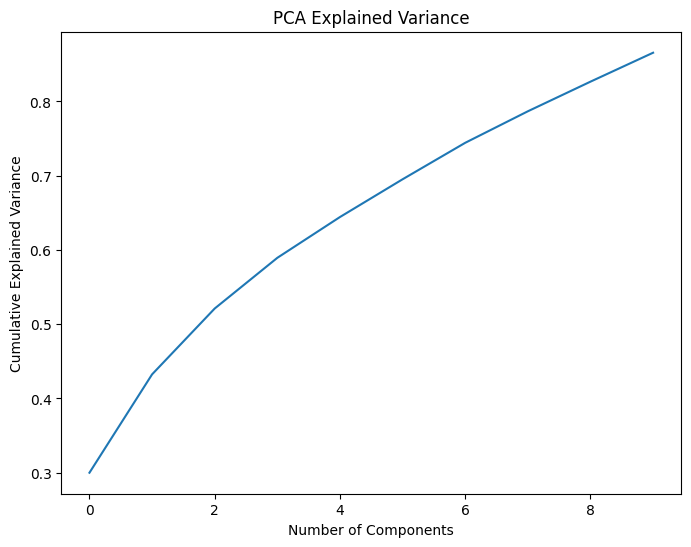

In [23]:

pca = PCA(n_components=10)  # Reduce to 10 components
X_pca = pca.fit_transform(X_train)

# Visualize PCA variance
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

## ii. LDA (supervised, for classification)

In [24]:
lda = LDA(n_components=1)  # Max components = classes-1 = 1
X_lda = lda.fit_transform(X_train, y_train)

#Validation and Training Models
We'll use Logistic Regression and Random Forest as classifiers.
Cross-validation with StratifiedKFold

Original Features:
LR Original Cross-Val F1: 0.7966835922337531
LR Original Test Accuracy: 0.7874396135265701
LR Original Test F1: 0.7987191216834401
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1035
           1       0.76      0.84      0.80      1035

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.79      2070
weighted avg       0.79      0.79      0.79      2070



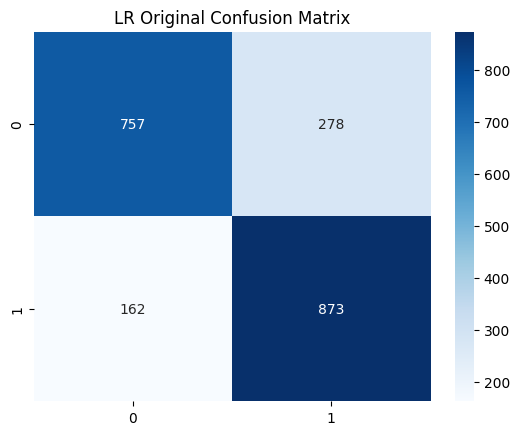

RF Original Cross-Val F1: 0.8365136952940271
RF Original Test Accuracy: 0.8405797101449275
RF Original Test F1: 0.8456501403180543
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.82      0.87      0.85      1035

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



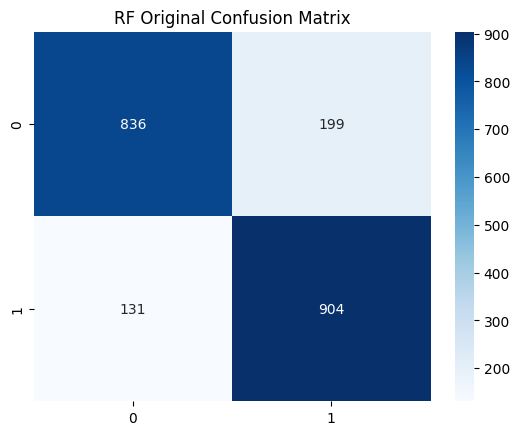

With PCA:
LR PCA Cross-Val F1: 0.777796005218169
LR PCA Test Accuracy: 0.7743961352657005
LR PCA Test F1: 0.7866605756052992
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1035
           1       0.75      0.83      0.79      1035

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070



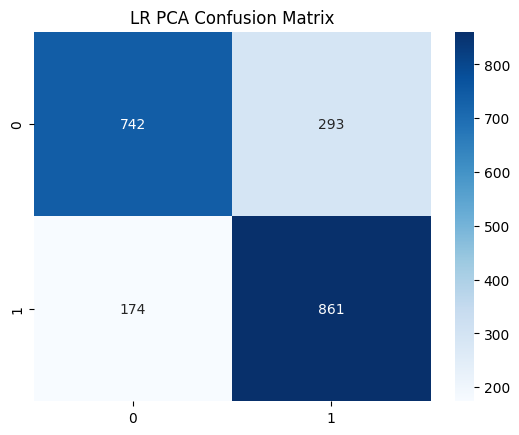

RF PCA Cross-Val F1: 0.8086829811304694
RF PCA Test Accuracy: 0.8183574879227054
RF PCA Test F1: 0.8236397748592871
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1035
           1       0.80      0.85      0.82      1035

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



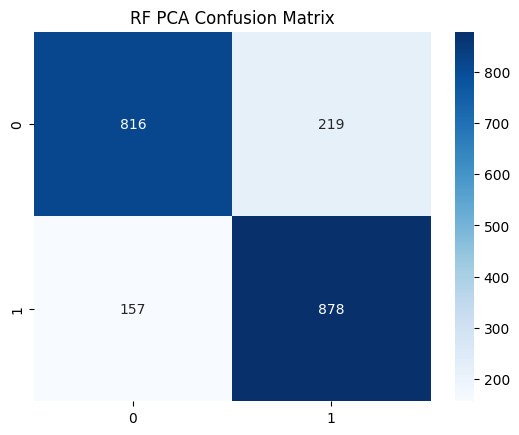

With LDA:
LR LDA Cross-Val F1: 0.7904004514446024
LR LDA Test Accuracy: 0.7811594202898551
LR LDA Test F1: 0.7892042810609586
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1035
           1       0.76      0.82      0.79      1035

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070



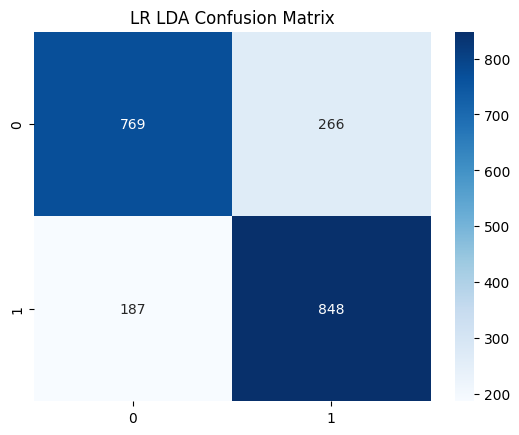

RF LDA Cross-Val F1: 0.7036866961289263
RF LDA Test Accuracy: 0.6932367149758454
RF LDA Test F1: 0.6924939467312349
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1035
           1       0.69      0.69      0.69      1035

    accuracy                           0.69      2070
   macro avg       0.69      0.69      0.69      2070
weighted avg       0.69      0.69      0.69      2070



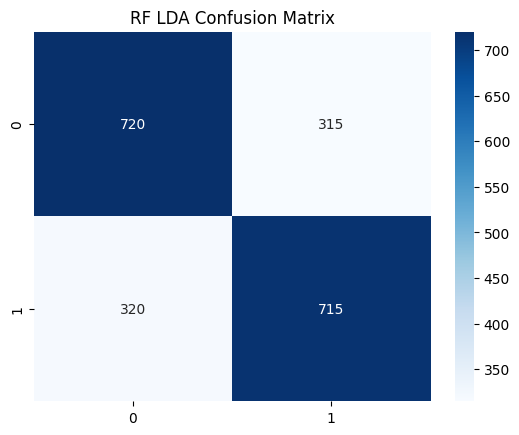

In [25]:
skf = StratifiedKFold(n_splits=5)

# Function to train and evaluate
def train_evaluate(model, X_train, y_train, X_test, y_test, label):
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    print(f"{label} Cross-Val F1: {scores.mean()}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{label} Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{label} Test F1: {f1_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{label} Confusion Matrix")
    plt.show()

# Models without reduction (using original resampled)
lr_original = LogisticRegression(max_iter=1000)
rf_original = RandomForestClassifier(random_state=42)

print("Original Features:")
train_evaluate(lr_original, X_train, y_train, X_test, y_test, "LR Original")
train_evaluate(rf_original, X_train, y_train, X_test, y_test, "RF Original")

# With PCA
X_test_pca = pca.transform(X_test)
lr_pca = LogisticRegression(max_iter=1000)
rf_pca = RandomForestClassifier(random_state=42)

print("With PCA:")
train_evaluate(lr_pca, X_pca, y_train, X_test_pca, y_test, "LR PCA")
train_evaluate(rf_pca, X_pca, y_train, X_test_pca, y_test, "RF PCA")

# With LDA
X_test_lda = lda.transform(X_test)
lr_lda = LogisticRegression(max_iter=1000)
rf_lda = RandomForestClassifier(random_state=42)

print("With LDA:")
train_evaluate(lr_lda, X_lda, y_train, X_test_lda, y_test, "LR LDA")
train_evaluate(rf_lda, X_lda, y_train, X_test_lda, y_test, "RF LDA")

#Evaluation
Rank influential features (from Random Forest feature importances)

In [26]:
rf_original.fit(X_train, y_train)
importances = pd.Series(rf_original.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances (RF):")
print(importances)

Feature Importances (RF):
MonthlyCharges      0.155724
TotalCharges        0.153272
tenure              0.150453
Contract            0.135500
OnlineSecurity      0.060287
TechSupport         0.059330
PaymentMethod       0.045278
InternetService     0.027885
OnlineBackup        0.027846
gender              0.024340
Dependents          0.024144
Partner             0.022273
PaperlessBilling    0.021229
DeviceProtection    0.020727
MultipleLines       0.020010
StreamingMovies     0.015773
StreamingTV         0.015766
SeniorCitizen       0.014646
PhoneService        0.005514
dtype: float64


# Visualize top features

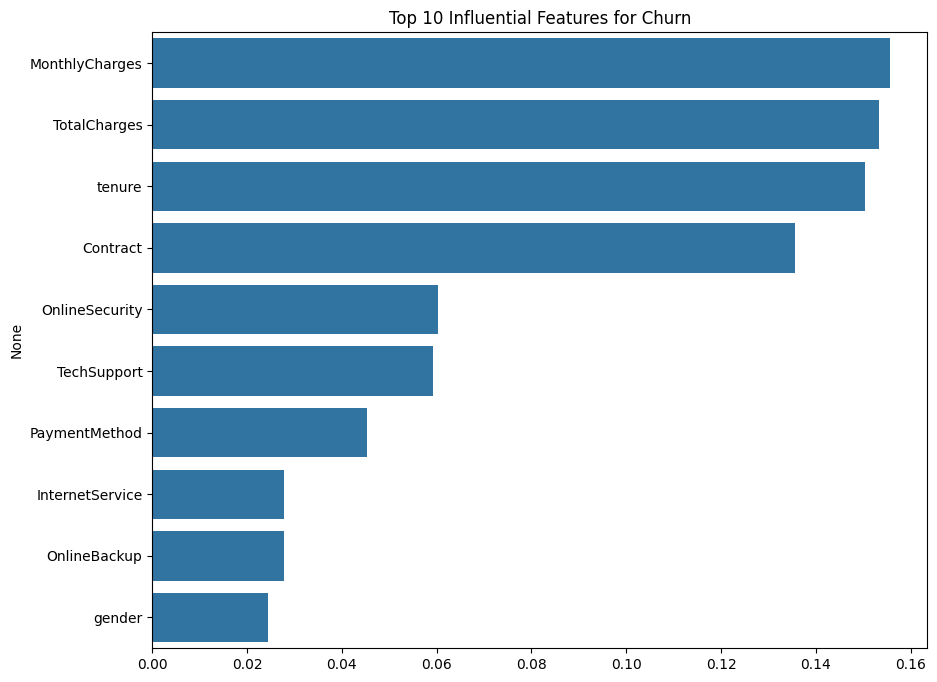

In [27]:
plt.figure(figsize=(10,8))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title('Top 10 Influential Features for Churn')
plt.show()